# Iterative Maximum Likelihood Estimation (iMLE)

## - Using the Husimi Q function measurement

Shahnawaz Ahmed, Chalmers University of Technology, Sweden  
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah

In [1]:
# imports 

import numpy as np

from qutip import Qobj, rand_dm, fidelity, displace, qdiags, qeye, expect
from qutip.states import coherent, coherent_dm, thermal_dm, fock_dm
from qutip.random_objects import rand_dm
from qutip.visualization import plot_wigner, hinton, plot_wigner_fock_distribution
from qutip.wigner import qfunc
import qutip

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation


from IPython.display import clear_output

### Introduction

Quantum State Tomography is the process of determining an unknown quantum state by making measurements on the system and using the measurement data to reconstruct the density matrix of the state. In this notebook, we will use QuTiP for Quantum State Tomography of a cavity state - the cat state. This notebook reproduces Fig 3 (a) of [1] for the iMLE method.

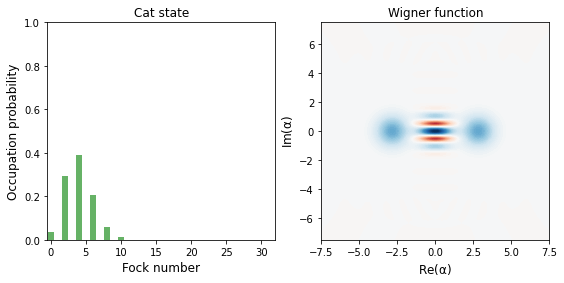

In [3]:
hilbert_size = 32
cat = coherent(hilbert_size, 2) + coherent(hilbert_size, -2) # We should also normalize with (1/sqrt(2))
cat = cat.unit() # QuTiP can normalize the state 

fig, ax = plot_wigner_fock_distribution(cat, figsize=(9, 4))
ax[0].set_title("Cat state")
plt.show()

## References
[1] Shahnawaz Ahmed, Carlos Sánchez Muñoz, Franco Nori, Anton Frisk Kockum. "Quantum State Tomography with Conditional Generative Adversarial Networks." https://arxiv.org/abs/2008.03240


[2] Shen, Chao, et al. "Optimized tomography of continuous variable systems using excitation counting." Physical Review A 94.5 (2016): 052327.  
Link: https://arxiv.org/abs/1606.07554

[3] Řeháček, J., Z. Hradil, and M. Ježek. "Iterative algorithm for reconstruction of entangled states." Physical Review A 63.4 (2001): 040303.

### Displacement operation

The measurement obervables considered here are photon number statistics (see [1, 2]). This type of measurement simply relies on finding the probability of observing a certain number of photons in the cavity, i.e., measuring the photon number operator (occupation) $|n \rangle  \langle n|$ after displacing the state by applying the displacement operator $$ D(\beta) = e^{\beta a^{\dagger} - \beta^*a}.$$

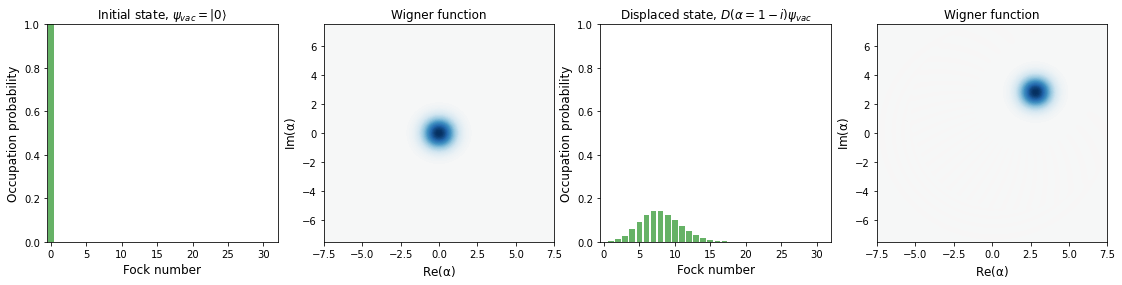

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(19, 4))

plot_wigner_fock_distribution(coherent(hilbert_size, 0), fig=fig, axes=[ax[0], ax[1]])
plot_wigner_fock_distribution(displace(hilbert_size, 2+2j)*coherent(32, 0), fig=fig, axes=[ax[2], ax[3]])

ax[0].set_title(r"Initial state, $\psi_{vac} = |0 \rangle$")
ax[2].set_title(r"Displaced state, $D(\alpha=1-i )\psi_{vac}$")
plt.show()

### Optical quantum states in the fock basis

In the fock basis, we can describe optical quantum states as $|\psi \rangle = \sum_n^{N_{cut}}p_n |n \rangle$, where $N_{cut}$ is the photon number cutoff which truncates the Hilbert space and $|{p_n}|^2$ is the probability of observing $n$ photons. The vaccum state $\psi_{vac} = |0 \rangle$ or a superposition of fock states containing two and three photons $\psi_{fock} = \frac{1}{\sqrt{2}}(|2 \rangle + |3 \rangle$ are some examples of simple optical quantum states. The coherent state is a displaced fock state $\psi_{\texttt{coherent}(\alpha)} = D(\alpha) |0 \rangle$ and a superposition of two such coherent states is defined as a CAT state,  
$$\psi_{\texttt{CAT}(\alpha)} = \frac{\psi_{\texttt{coherent}}(\alpha) + \psi_{\texttt{coherent}}(-\alpha)}{\sqrt{2}}$$

### Displace and measure - the generalized Q function

The expectation value of the photon number operators after applying a displacement $D(\beta_i)$ to the state density matrix $\rho = |\psi  \rangle \langle \psi|$ forms the so-called generalised $Q$ function:

$$Q_n^{\beta} = Tr[|n \rangle \langle n|D(-\beta) \rho D^\dagger(-\beta)$$

This type of "displace-and-measure" techniques can be seen as a generalization of some of the known observables in quantum optics, e.g., Husimi Q function $Q_0^{\beta}$ which measures the vaccum state probability or the Wigner function which measures photon parity, $W(\beta) = \sum_n (-1)^n Q_n^{\beta}$.

### Displace and measure - the Husimi Q function

The Husimi Q function represents just one level of the generalized Q function measurement (n=0). As such, in case of such a measurement for tomography, we might need to provide more datapoints (multiple $\beta$ values). Here we consider a grid of beta values $32 \times 32$

In [29]:
def measure_q(beta, rho):
    """
    Measures the generalized q function values for the state density matrix.
    
    Parameters
    ----------    
    beta: np.complex
        A complex displacement.

    rho:
        The density matrix as a QuTiP Qobj (`qutip.Qobj`)

    Returns
    -------
    population: ndarray
        A 1D array for the probabilities for populations.
    """
    hilbertsize = rho.shape[0]
    # Apply a displacement to the state and then measure the diagonals.

    D = displace(hilbertsize, beta)
    rho_disp = D*rho*D.dag()
    
    # measure all the elements in the diagonal
    populations = np.real(np.diagonal(rho_disp.full()))
    return populations


# convert to density matrix
rho = cat*cat.dag()

beta_max = 5
num_grid = 32

xvec = np.linspace(-beta_max, beta_max, num_grid)
yvec = np.linspace(-beta_max, beta_max, num_grid)

X, Y = np.meshgrid(xvec, yvec)

# The division by sqrt(2) is just to follow the convention in QuTiP
betas = (X + 1j*Y)/np.sqrt(2)

generalized_Q = np.array([measure_q(b, rho) for b in np.ravel(betas)])

In [34]:
qutip_qfunc_values = qfunc(rho, xvec, yvec)

# The pre-factor (1/2 pi) is used to match the scaling for hbar in QuTiP
prefactor = (1/(2*np.pi))
husimi_Q = prefactor*generalized_Q[:, 0]

print(np.allclose(qutip_qfunc_values.ravel(), husimi_Q))

True


# We can visualize the levels of the generalized Q function in a grid (n=0 is Husimi Q)

Notice that the second level of the generalized Q function shows patterns between the two blobs of the cat state similar to the fringes in the Wigner function.

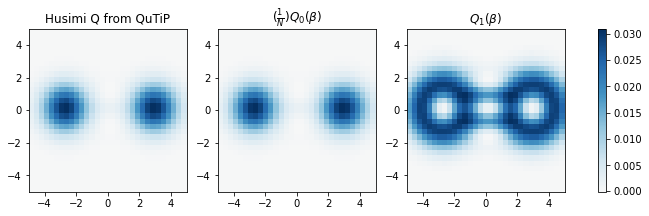

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
grid_shaped_Q = generalized_Q.reshape(num_grid, num_grid, hilbert_size)


norm = colors.TwoSlopeNorm(vmin=-1e-9, vcenter=0, vmax=np.max(qutip_qfunc_values))
im = ax[0].pcolor(xvec, yvec,
                  qutip_qfunc_values, # $Q(|beta)_0$
                  norm = norm,
                  cmap="RdBu")

norm = colors.TwoSlopeNorm(vmin=-1e-9, vcenter=0, vmax=np.max(prefactor*grid_shaped_Q[:, :, 0]))
im = ax[1].pcolor(xvec, yvec,
                  prefactor*grid_shaped_Q[:, :, 0], # $Q(|beta)_0$
                  norm = norm,
                  cmap="RdBu")

norm = colors.TwoSlopeNorm(vmin=-1e-9, vcenter=0, vmax=np.max(prefactor*grid_shaped_Q[:, :, 1]))
im2 = ax[2].pcolor(xvec, yvec,
                  prefactor*grid_shaped_Q[:, :, 1], # $Q(|beta)_0$
                  norm = norm,
                  cmap="RdBu")

plt.colorbar(im2, ax=[ax[0], ax[1], ax[2]])
ax[0].set_title(r"Husimi Q from QuTiP")
ax[1].set_title(r"$(\frac{1}{N})Q_0(\beta)$")
ax[2].set_title(r"$Q_1(\beta)$")
plt.show()

# Data

The data is now the Husimi Q function values for the $32 \times 32$ grid and we can reconstruct the full cat state density matrix from these points. Then, using the measurement data, one can use some statistical inference technique such as iterative Maximum Likelihood Estimation [3] to reconstruct the density matrix.

### Iterative Maximum Likelihood Estimation

The measurement statistics from different measurement settings, i.e., values of displacements could be made informationally complete such that they contain the full information required to reconstruct the state, (see Ref [2]). Once we have the data, the iterative Maximum Likelihood Estimation (iMLE) method [3] can be used to start from a random guess of the density matrix and determine the full density matrix by repeatedly applying an operator $R$ to a randomly initialized density matrix.

$R$ is a sum of projection operators into the measured basis - the displaced photon number operator in this case, $M_i = D(\beta_i) |n \rangle \langle n|  D^{\dagger}(\beta_i)$. Each such operator is weighted by the ratio of observed frequency of the measurement (empirical probability from experimental data, $d_i$) and the estimate of the same from the density matrix, $Tr[M_i \rho]$

$$R = \sum_i \frac{d_i}{Tr[M_i \rho]} M_i$$

Then we iteratively apply $R$ as $R \rho R$ until convergence to get the density matrix from the measured data.

Note that for the Husimi Q function as the measurement operator, the R operators are just projections onto coherent states since, $$M_i = \frac{1}{2\pi} D(\beta_i) |0 \rangle \langle 0|  D^{\dagger}(\beta_i) = \frac{1}{2\pi} |\beta_i \rangle \langle \beta_i|$$

### Constructing the R operators

In [39]:
def construct_R(hilbert_size, betas):
    """
    Calculates the operators R in a displace and measure method.

    Parameters
    ----------
    hilbert_size (int):
        The hilbert space size
    beta: list_like
        A list of the displacements that were applied to the state before
        measurement.

    Returns
    -------
    R: `qutip.Qobj`
        The iterative operator which we are going to apply for state
        reconstruction.
    """
    R_ops = []

    for beta in betas:
        R_ops.append(coherent_dm(hilbert_size, beta))

    return R_ops


betas = betas.ravel()
r_ops = construct_R(hilbert_size, betas)

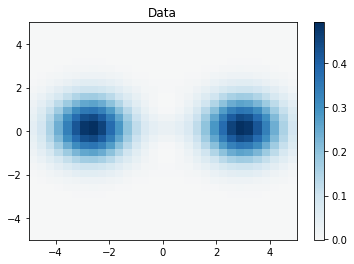

In [41]:
# We discard the scaling pre-factor since it will be cancelled in the ratio

data = np.array([expect(r_ops[i], rho) for i in range(len(betas))])

norm = colors.TwoSlopeNorm(vmin=-1e-9, vcenter=0, vmax=np.max(data))
im = plt.pcolor(xvec, yvec,
           data.reshape(32, 32), # proportional to $Q(|beta)_0$
           norm = norm,
           cmap="RdBu")

plt.title("Data")
plt.colorbar(im)
plt.show()

### Reconstruct the cat state density matrix from the Husimi Q function data

Note that for 10000 iterations (which reproduces Fig 3 (a) of [1]), it might take a couple of minutes to run. The number of iterations can be changed using the `max_iter` term.

In [46]:
max_iter = 1000

rho_reconstructed = rand_dm(hilbert_size) # Random initial dm
rho_t = []
rho_t.append(rho_reconstructed)

fidelities = [fidelity(rho_reconstructed, rho)]

for iterations in range(max_iter):
    R = 0*qeye(hilbert_size)

    for i in range(len(betas)):
        r = r_ops[i]
        R += (data[i]/(expect(r, rho_reconstructed)))*r

    rho_reconstructed = R*rho_reconstructed*R

    # Trace renormalization
    rho_reconstructed = rho_reconstructed/rho_reconstructed.tr()
    rho_t.append(rho_reconstructed)

    # Compute fidelity
    f = fidelity(rho_reconstructed, rho)
    fidelities.append(f)

    print(r"Iteration {}; Fidelity: {}".format(iterations, f))
    clear_output(wait=True)

Iteration 999; Fidelity: 0.9634668850645659


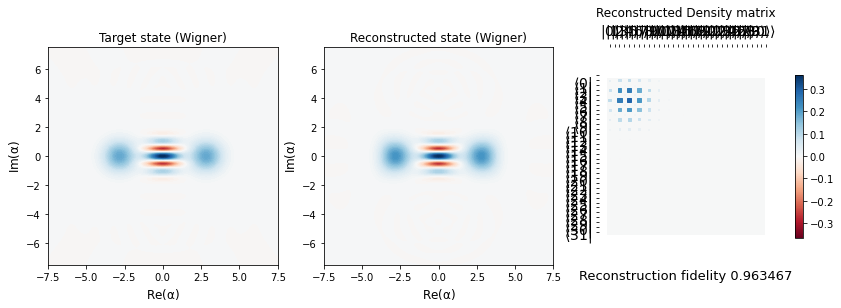

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
plot_wigner(rho_reconstructed, fig=fig, ax=ax[1])
plot_wigner(rho, fig=fig, ax=ax[0], cmap="RdBu")
hinton(rho_t[-1], ax=ax[2])

ax[0].set_title("Target state (Wigner)")
ax[1].set_title("Reconstructed state (Wigner)")
ax[2].set_title("Reconstructed Density matrix")
ax[2].set_xlabel("Reconstruction fidelity {:2f}".format(fidelity(rho_reconstructed, rho)), fontsize=13)

plt.show()

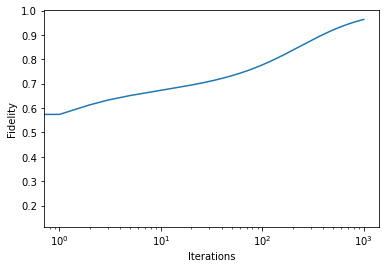

In [48]:
plt.semilogx(fidelities)
plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.show()

# QuTiP details

In [49]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Current admin team: Alexander Pitchford, Paul D. Nation, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, and Boxi Li
Project Manager: Franco Nori.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.5.0.dev0+dcda03a0
Numpy Version:      1.18.5
Scipy Version:      1.4.1
Cython Version:     0.29.15
Matplotlib Version: 3.2.2
Python Version:     3.7.6
Number of CPUs:     10
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Linux (x86_64)
Installation path:  /home/shahnawaz/dev/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
